In [11]:
# Simulating wiring rules in silico
### Demonstration of how to simulate connectomes using the three rule variants used in the paper.

import matplotlib.pyplot as plt
import numpy as np
import torch


from torch.distributions import MultivariateNormal

from consbi.simulators import DistanceRuleSimulator, RuleSimulator, poisson_glm, peters_rule_subcellular
from consbi.simulators import default_rule
from consbi import DATA_PATH, RESULTS_PATH

from sbi.inference import prepare_for_sbi, simulate_for_sbi
from sbi.utils import BoxUniform
plt.style.use('../plotting_settings.mplstyle')
%matplotlib inline

## Generalized DSO-rule

The simulator is applied to the full barrel cortex column with more then 14 million neuron-pair-subvolume combinations, and summary statistics are calculated. The summary statistics are calculated to match the seven connection probabilities measured experimentally between VPM and barrel cortex. The mapping from 14 million generate synapse counts to the seven summary statistics is highly non-linear and implies that we have to use SBI to perform parameter inference.





In [15]:
path_to_model = DATA_PATH.joinpath("structural_model")
# set number of neuron pairs sampled from the connectome to mimick experimental settings, e.g., 50
num_subsampling_pairs = 50

simulator = RuleSimulator(path_to_model, default_rule, verbose=True, num_subsampling_pairs=num_subsampling_pairs)

Loading features, this may take a while...
Time elapsed: 156.53995537757874


/home/janfb/qode/sbi-for-connectomics/consbi/simulators/rule_simulator.py:654: RuntimeWarning: invalid value encountered in log
  log_features = np.log(features)


constraint 0, num rows (with overlap) 2168393
constraint 1, num rows (with overlap) 687074
constraint 2, num rows (with overlap) 308345
constraint 3, num rows (with overlap) 674175
constraint 4, num rows (with overlap) 559727
constraint 5, num rows (with overlap) 587659
constraint 6, num rows (with overlap) 1096435


## Design correlated prior

In [178]:
# th1_2 = 0.2
th1_3 = 0.7
th2_3 = 0.8
cov = torch.tensor([[1., th1_2, th1_3], 
                    [th1_2, 1., th2_3], 
                    [th1_3, th2_3, 1.]])
corr_dist = torch.distributions.MultivariateNormal(torch.zeros(3), 
                                                   cov)
corr_samples = corr_dist.sample((1000,))

In [179]:
from sbi.analysis import pairplot

In [180]:
copula_samples = (torch.distributions.Normal(0, 1).cdf(corr_samples)) * 3

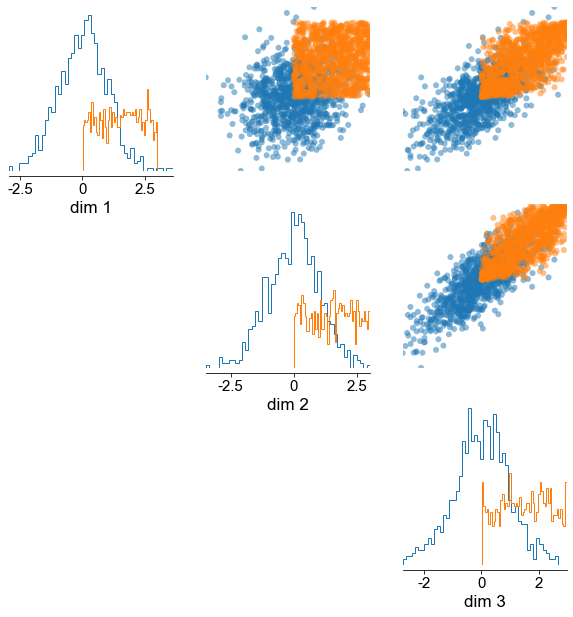

In [181]:
pairplot([corr_samples, copula_samples], upper="scatter");

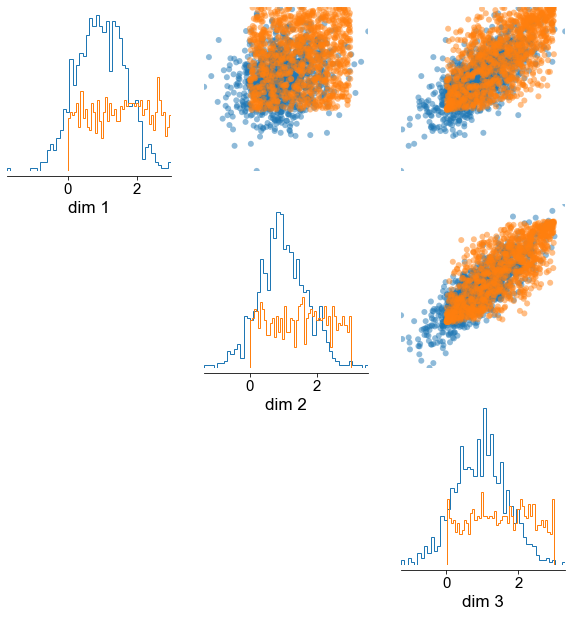

In [182]:
pairplot([MultivariateNormal(torch.ones(3), 0.5 * cov).sample((1000,)),
         copula_samples], upper="scatter", );

In [158]:
from sbi.simulators import simulate_in_batches

x = simulate_in_batches(simulator, corr_samples, num_workers=24, )

In [183]:
num_simulations = 1000
# wrap the simulator to handle batches of parameters
batch_simulator, prior = prepare_for_sbi(simulator, MultivariateNormal(torch.ones(3), 0.5 * cov))



theta, x = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, 
                            num_workers=20, 
                            simulation_batch_size=1)


In [125]:
num_simulations = 1000
# wrap the simulator to handle batches of parameters
batch_simulator, prior = prepare_for_sbi(simulator, MultivariateNormal(torch.ones(3), 0.5 * torch.eye(3)))

theta3, x3 = simulate_for_sbi(batch_simulator, prior, num_simulations=num_simulations, 
                            num_workers=20, 
                            simulation_batch_size=1)


/home/janfb/anaconda3/envs/spp/lib/python3.7/site-packages/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/anaconda3/envs/spp/lib/python3.7/site-packages/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


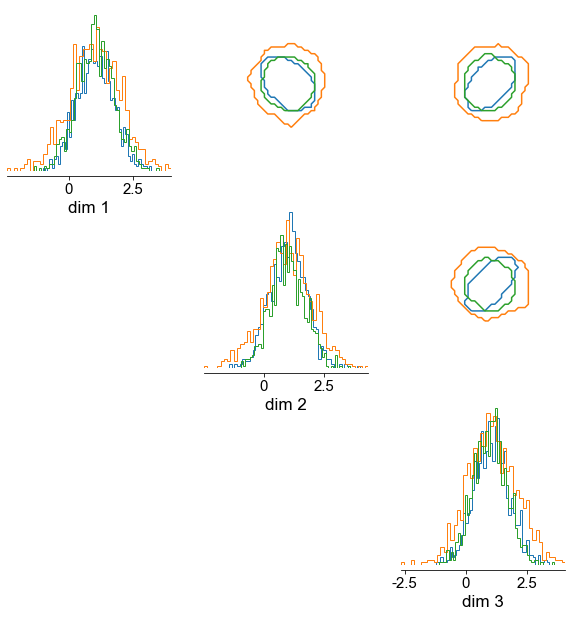

In [126]:
pairplot([theta, theta2, theta3], upper="contour",);

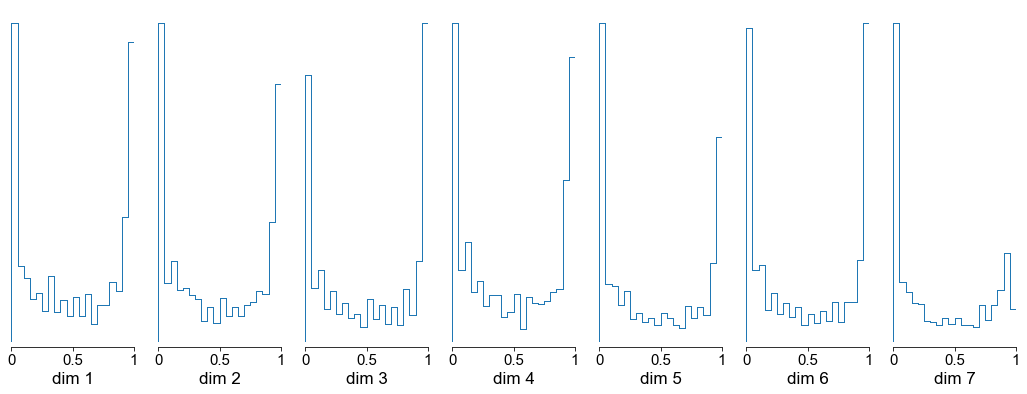

In [185]:
from sbi.analysis import marginal_plot
marginal_plot([x, 
#                x2, 
#                x3
              ], hist_diag=dict(histtype="step", bins=20, alpha=.6), figsize=(18, 6));